# Web Log Anomaly Detection

### Import Modules

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Getting Spark Session & Context

In [ ]:
spark = SparkSession.builder \
                    .master("spark://node-201:7077") \
                    .appName("Web Log Anomaly Detection") \
                    .config("spark.submit.deployMode", "client") \
                    .config("spark.executor.instances", "4") \
                    .config("spark.executor.memory", "8g") \
                    .config("spark.executor.cores", "8") \
                    .enableHiveSupport() \
                    .getOrCreate()
sc = spark.sparkContext

### Apache Access Log Parser

In [ ]:
import re
from dateutil import parser
from pyspark.sql import Row

#APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)? ?(\S+)? ?(\S+)?" (\d{3}) ([\d-]+) ?"?([^"]+)?"? ?"?([^"]+)?"?'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] '
pattern = re.compile(APACHE_ACCESS_LOG_PATTERN)

def apache_access_log_parse(line):
    row = None

    try:
        m = pattern.match(line)

        time = m.group(4)
        time = parser.parse(time.replace(':', ' ', 1))

        #date = time.strftime('%Y%m%d')

        #size = m.group(9)
        #if size == '-': size = 0
        #else: size = long(size)

        row = Row(#host     = m.group(1),
                  #identity = m.group(2),
                  #user     = m.group(3),
                  time     = time)
                  #method   = m.group(5),
                  #url      = m.group(6),
                  #protocol = m.group(7),
                  #status   = m.group(8),
                  #size     = size,
                  #referer  = m.group(10),
                  #agent    = m.group(11),
                  #date     = date)
    except:
        print "apache access log parsing error : ", line

    return row

### Loading Data

In [ ]:
LOG_FILE_PATH = 'hdfs://node-201:9000/data/weblog/2015'
rdd = sc.textFile(LOG_FILE_PATH) \
        .map(apache_access_log_parse) \
        .filter(lambda x: x is not None)
df = spark.createDataFrame(rdd)

In [ ]:
df.show(10, False)

### 1. 요청 건수 이상 탐지

#### 요청 건수 가져오기

In [ ]:
request_cnt_df = df.groupby('time').count().sort('time')

#### Pandas 로 변환

In [ ]:
request_cnt_pdf = request_cnt_df.toPandas()
request_cnt_pdf = request_cnt_pdf.set_index('time')

#### 샘플링

In [ ]:
request_cnt = request_cnt_pdf.resample('1S').sum()

In [ ]:
'''
# 기존에 비효율적으로 작성한 코드.
# 카운트 타입이기 때문에 0으로 설정.
start = request_cnt_pdf.index[0]
end = request_cnt_pdf.index[-1]
index = pd.date_range(start=start, end=end, freq='s')
data = [0] * index.size
request_cnt = pd.DataFrame(data=data, index=index, columns=['count'])
request_cnt.update(request_cnt_pdf)
'''

#### 이동 평균 추가

In [ ]:
#request_cnt['MA20'] = request_cnt['count'].rolling(20).mean()
#request_cnt['MS20'] = request_cnt['count'].rolling(20).std()

#### 체크포인트 생성/로드

In [2]:
# pickle
request_cnt = pd.read_pickle('request_cnt_2015.pkl')
#request_cnt.to_pickle('request_cnt_2015.pkl')

In [ ]:
# HDFS


#### 데이터 확인

In [ ]:
print request_cnt.describe()
#request_cnt.head(10)
request_cnt.sort_values(['count'], ascending=[False])[:10]

#### 데이터 샘플링

In [3]:
request_cnt_t = request_cnt.resample('1T').sum()
request_cnt_5t = request_cnt.resample('5T').sum()
request_cnt_10t = request_cnt.resample('10T').sum()
request_cnt_30t = request_cnt.resample('30T').sum()
request_cnt_60t = request_cnt.resample('60T').sum()

#### 이동평균 추가

In [ ]:
#request_cnt_t['MA20'] = request_cnt_t['count'].rolling(20).mean()
#request_cnt_5t['MA20'] = request_cnt_5t['count'].rolling(20).mean()
#request_cnt_10t['MA20'] = request_cnt_10t['count'].rolling(20).mean()
#request_cnt_30t['MA20'] = request_cnt_30t['count'].rolling(20).mean()
#request_cnt_60t['MA20'] = request_cnt_60t['count'].rolling(20).mean()

In [ ]:
#request_cnt_t['MS20'] = request_cnt_t['count'].rolling(20).std()
#request_cnt_5t['MS20'] = request_cnt_5t['count'].rolling(20).std()
#request_cnt_10t['MS20'] = request_cnt_10t['count'].rolling(20).std()
#request_cnt_30t['MS20'] = request_cnt_30t['count'].rolling(20).std()
#request_cnt_60t['MS20'] = request_cnt_60t['count'].rolling(20).std()

In [ ]:
#request_cnt_t['pct_change'] = request_cnt_t['count'].pct_change()
#request_cnt_5t['pct_change'] = request_cnt_5t['count'].pct_change()
#request_cnt_10t['pct_change'] = request_cnt_10t['count'].pct_change(periods=10)
#request_cnt_30t['pct_change'] = request_cnt_30t['count'].pct_change()
#request_cnt_60t['pct_change'] = request_cnt_60t['count'].pct_change()

In [ ]:
# additive
#request_cnt_t['detrend'] = request_cnt_t['count'] - request_cnt_t['MA20']
#request_cnt_5t['detrend'] = request_cnt_5t['count'] - request_cnt_5t['MA20']
#request_cnt_10t['detrend'] = request_cnt_10t['count'] - request_cnt_10t['MA20']
#request_cnt_30t['detrend'] = request_cnt_30t['count'] - request_cnt_30t['MA20']
#request_cnt_60t['detrend'] = request_cnt_60t['count'] - request_cnt_60t['MA20']

#### 사용할 데이터 선택

In [4]:
#request_cnt_dat = request_cnt_60t.loc['2015-12-07':]
request_cnt_dat = request_cnt_t.loc['2015-12-07':]

#### Y 값 세팅

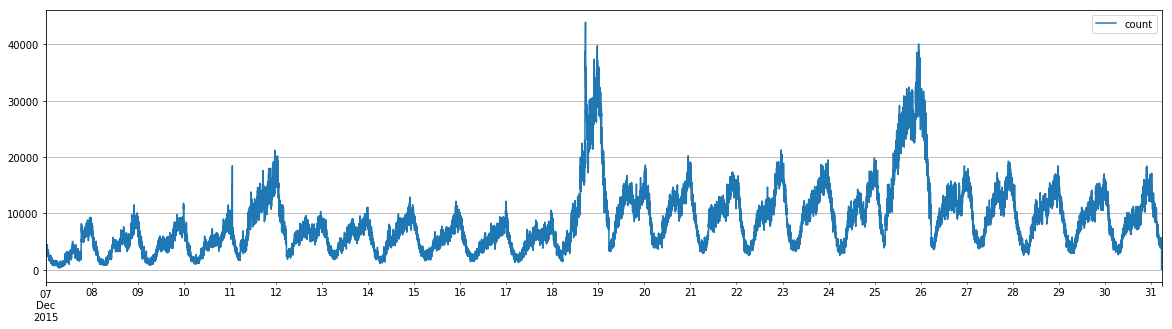

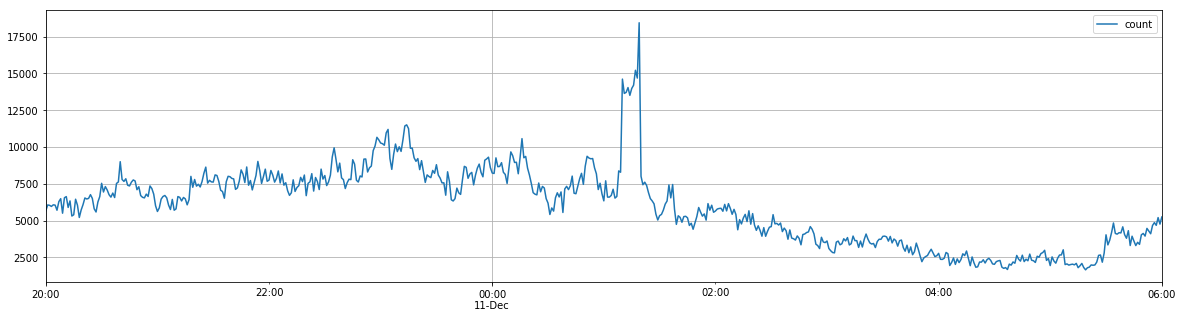

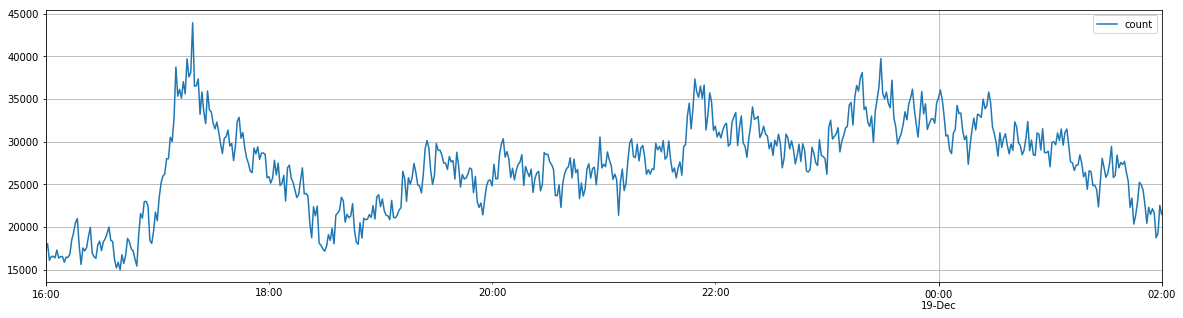

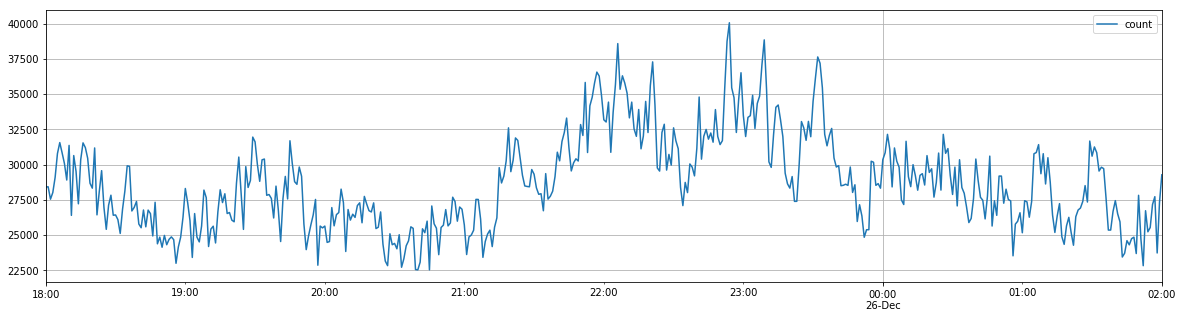

In [5]:
# 그래프 상에서 이상점 확인
request_cnt_dat.loc['2015-12-07':'2015-12-31', ['count']].plot(figsize=(20,5), grid=True)
request_cnt_dat.loc['2015-12-10 20:00:00':'2015-12-11 06:00:00', ['count']].plot(figsize=(20,5), grid=True)
request_cnt_dat.loc['2015-12-18 16:00:00':'2015-12-19 02:00:00', ['count']].plot(figsize=(20,5), grid=True)
request_cnt_dat.loc['2015-12-25 18:00:00':'2015-12-26 02:00:00', ['count']].plot(figsize=(20,5), grid=True)

In [312]:
# 이상점 y 값 설정.
request_cnt_dat.loc[:,'y'] = 0
# 1T
request_cnt_dat.loc['2015-12-11 01:10:00':'2015-12-11 01:19:00', 'y'] = 1
#request_cnt_dat.loc['2015-12-18 14:40:00':'2015-12-18 14:46:00', 'y'] = 1 # 비고: 분석을 통해 찾아낸 이상치.
request_cnt_dat.loc['2015-12-18 17:05:00':'2015-12-18 17:29:00', 'y'] = 1

# 10T
#request_cnt_dat.loc['2015-12-18 17:00:00', 'y'] = 1
#request_cnt_dat.loc['2015-12-18 17:10:00', 'y'] = 1
#request_cnt_dat.loc['2015-12-18 17:20:00', 'y'] = 1
#request_cnt_dat.loc['2015-12-18 17:30:00', 'y'] = 1
# 60T
#request_cnt_dat.loc['2015-12-18 17:00:00', 'y'] = 1

# 시각화를 위한 이상점 값 추가 저장.
request_cnt_dat.loc[request_cnt_dat['y']==0, 'anomaly'] = np.nan
request_cnt_dat.loc[:,'anomaly'].update(request_cnt_dat.loc[request_cnt_dat['y']==1, 'count'])

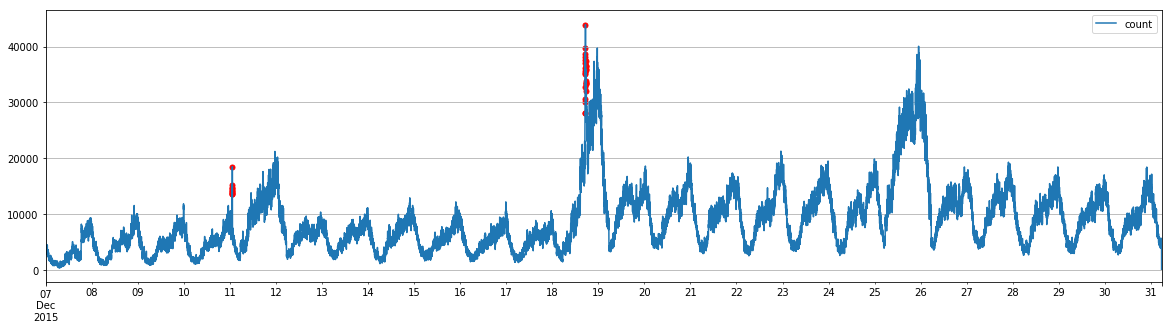

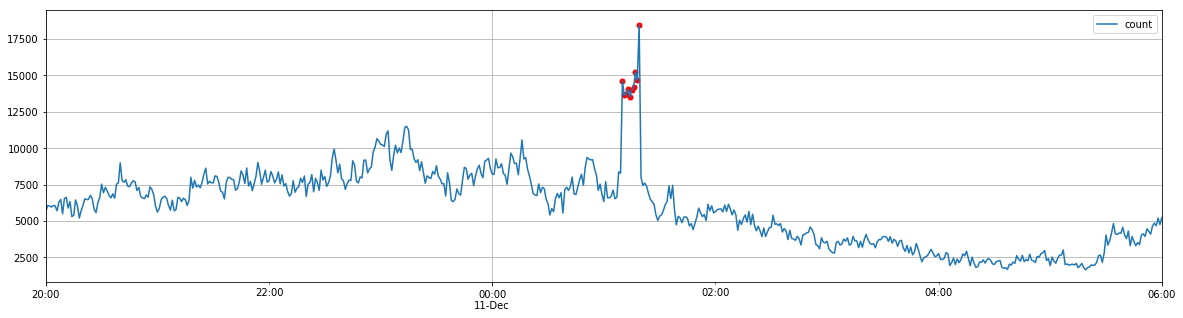

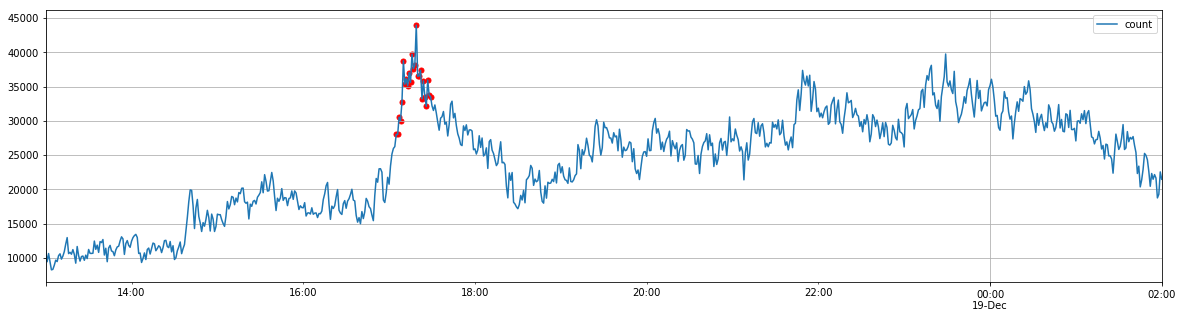

In [313]:
# 그래프 상에 이상점 표시
ax = request_cnt_dat.loc['2015-12-07':'2015-12-31', ['count']].plot(figsize=(20,5), grid=True)
ax.scatter(request_cnt_dat['2015-12-07':'2015-12-31'].index, request_cnt_dat.loc['2015-12-07':'2015-12-31', 'anomaly'], color='red', marker='o', s=5**2)

ax = request_cnt_dat.loc['2015-12-10 20:00:00':'2015-12-11 06:00:00', ['count']].plot(figsize=(20,5), grid=True)
ax.scatter(request_cnt_dat['2015-12-10 20:00:00':'2015-12-11 06:00:00'].index, request_cnt_dat.loc['2015-12-10 20:00:00':'2015-12-11 06:00:00', 'anomaly'], color='red', marker='o', s=5**2)

ax = request_cnt_dat.loc['2015-12-18 13:00:00':'2015-12-19 02:00:00', ['count']].plot(figsize=(20,5), grid=True)
ax.scatter(request_cnt_dat['2015-12-18 13:00:00':'2015-12-19 02:00:00'].index, request_cnt_dat.loc['2015-12-18 13:00:00':'2015-12-19 02:00:00', 'anomaly'], color='red', marker='o', s=5**2)


#### Extract Features

In [314]:
X = request_cnt_dat.loc[:'2015-12-21 23:59:59', ['count']]
y = request_cnt_dat.loc[:'2015-12-21 23:59:59', ['y']]

i = 0
ws = 6 * 10 * 24 * 3 + 2
#ws = 60 * 24 + 2
ts = len(X)
f_name = '3MRS'.format(ws)
print ws, ts, f_name

for start, end in zip(range(0, ts-ws+1),range(ws, ts+1)):
    #print start, end
    if i % int(float(ts-ws)/100) == 0: print "progress ... {}%".format(int(i/float(ts-ws)*100))
    i += 1
    window = X[start:end]['count']
    #print d
    result = seasonal_decompose(window, model='additive', freq=24*6*10, two_sided=False)
    idx = window.index[-1]
    
    mean = result.resid.mean()
    std = result.resid.std()
    resid = result.resid[-1]
    #print mean, std, resid
    #X.loc[idx, 'resid_mean'] = mean
    #X.loc[idx, 'resid_std'] = std
    #X.loc[idx, 'resid'] = resid
    #X.loc[idx, 'sigma'] = (resid - mean) / std
    X.loc[idx, f_name] = (resid - mean) / std
    #print X.loc[idx, f_name]
    
    #result.plot()
    #figure = result.plot()
    #figure.set_size_inches((20,10))
    #break

print 'finished'


4322 21600 3MRS
progress ... 0%
progress ... 0%
progress ... 1%
progress ... 2%
progress ... 3%
progress ... 4%
progress ... 5%
progress ... 6%
progress ... 7%
progress ... 8%
progress ... 9%
progress ... 10%
progress ... 11%
progress ... 12%
progress ... 13%
progress ... 14%
progress ... 15%
progress ... 16%
progress ... 17%
progress ... 18%
progress ... 19%
progress ... 20%
progress ... 21%
progress ... 22%
progress ... 23%
progress ... 24%
progress ... 25%
progress ... 26%
progress ... 27%
progress ... 28%
progress ... 29%
progress ... 30%
progress ... 31%
progress ... 32%
progress ... 33%
progress ... 34%
progress ... 35%
progress ... 36%
progress ... 37%
progress ... 38%
progress ... 39%
progress ... 40%
progress ... 41%
progress ... 42%
progress ... 43%
progress ... 44%
progress ... 45%
progress ... 46%
progress ... 47%
progress ... 48%
progress ... 49%
progress ... 50%
progress ... 51%
progress ... 52%
progress ... 53%
progress ... 54%
progress ... 55%
progress ... 56%
progress 

#### Clean up

In [315]:
#print X[X[f_name].notnull()].sort_values([f_name], ascending=[False])[:100]
indices = X[f_name].notnull()
X = X[indices]
y = y[indices]

#### Visualization

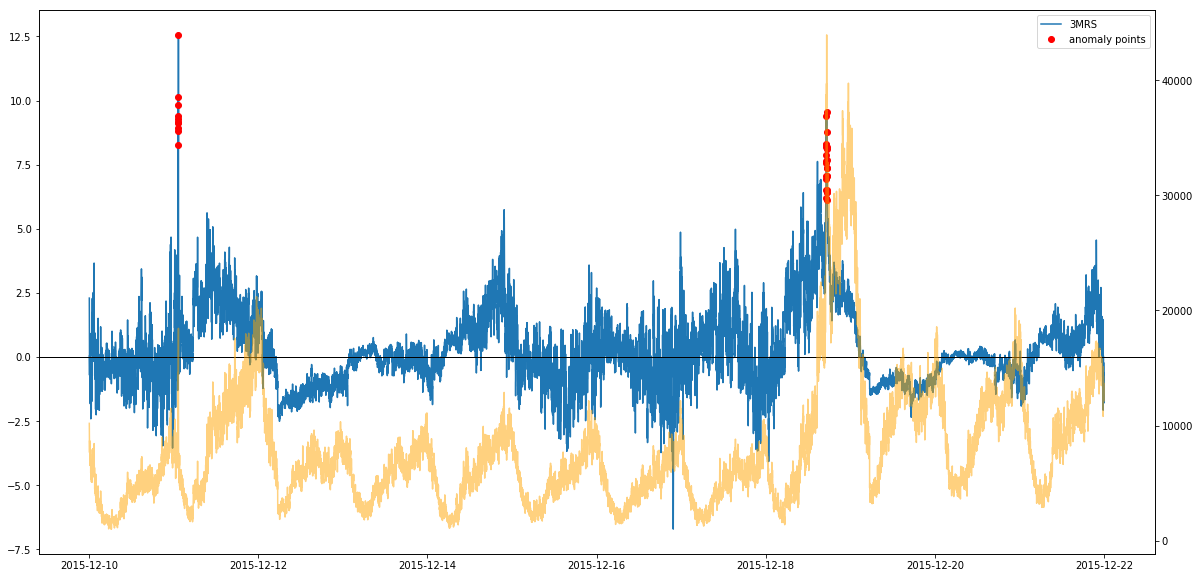

In [381]:
fig = plt.figure()
plt.plot(X['3MRS'], label='3MRS')
plt.plot(X[y['y']==1]['3MRS'], 'o', color='red', label='anomaly points')
plt.axhline(y=0, linewidth=1, linestyle='-', color='black')
plt.legend(loc='best')
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(X['count'], color='orange', alpha=0.5, label='count')
#ax2.legend(loc='best')
fig.set_size_inches((20,10))

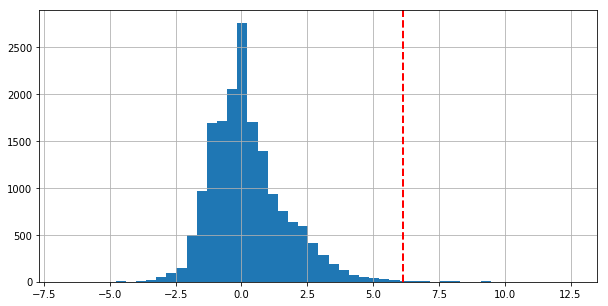

In [390]:
mean = X['3MRS'].mean()
std = X['3MRS'].std()
ax = X['3MRS'].hist(bins=50)
#threshold = mean + (3.2*std)
#threshold = mean+(5.0*std)
ax.axvline(x=X[y['y']==1]['3MRS'].min(), linewidth=2, linestyle='dashed', color='red')
figure = ax.get_figure()
figure.set_size_inches((10,5))
plt.show()

#### Split into training and test set

In [362]:
# 학습/테스트 세트로 나누기
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[['3MRS']], 
                                                    y[['y']], 
                                                    test_size=0.2, 
                                                    random_state=None,
                                                    shuffle=True)
#print X_train, X_test, y_train, y_test
#print y_train[y_train['y']==1]
#print y_test[y_test['y']==1]

#### Choose cross-validation iterator

In [363]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.35, random_state=None)
'''
for train_index, test_index in cv.split(X_train['3MRS'].values, y_train['y'].values):
    #print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = 
    print X_train.iloc[train_index], X_train.iloc[test_index]
    #y_train, y_test = 
    print y_train.iloc[train_index], y_train.iloc[test_index]
'''

'\nfor train_index, test_index in cv.split(X_train[\'3MRS\'].values, y_train[\'y\'].values):\n    #print("TRAIN:", train_index, "TEST:", test_index)\n    #X_train, X_test = \n    print X_train.iloc[train_index], X_train.iloc[test_index]\n    #y_train, y_test = \n    print y_train.iloc[train_index], y_train.iloc[test_index]\n'

#### Choose estimator

In [364]:
from sklearn.svm import SVC
estimator = SVC()

In [378]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(penalty='l1')

#### Tune the hyperparameters

In [379]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]} #np.linspace(0.0001, 10.0, 10)}
    #{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}, 
    #{'kernel': ['rbf'], 'gamma': np.logspace(-6, -1, 10), 'C': [1, 10, 100, 1000]}, 
    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
]
clf = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=6, scoring='recall') # f1_micro
clf.fit(X_train, y_train['y'])

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.35,
            train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [380]:
from sklearn.metrics import classification_report

scores = ['precision_macro', 'recall_macro']

#for score in scores:
#print("# Tuning hyper-parameters for %s" % score)
#print()

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test['y'], clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

'''
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3446
          1       1.00      0.80      0.89        10

avg / total       1.00      1.00      1.00      3456
'''


Best parameters set found on development set:
()
{'C': 13}
()
Grid scores on development set:
()
0.000 (+/-0.000) for {'C': 0.0001}
0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.322 (+/-0.210) for {'C': 0.1}
0.600 (+/-0.204) for {'C': 1}
0.678 (+/-0.210) for {'C': 10}
0.678 (+/-0.210) for {'C': 11}
0.678 (+/-0.210) for {'C': 12}
0.689 (+/-0.194) for {'C': 13}
0.689 (+/-0.194) for {'C': 14}
0.689 (+/-0.194) for {'C': 15}
0.689 (+/-0.194) for {'C': 16}
0.689 (+/-0.194) for {'C': 17}
0.689 (+/-0.194) for {'C': 18}
0.689 (+/-0.194) for {'C': 19}
0.689 (+/-0.194) for {'C': 20}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3446
          1       1.00      0.80      0.89        10

avg / total       1.00      1.00      1.00      3456

()


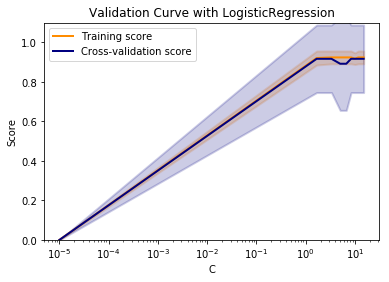

In [433]:
from sklearn.model_selection import validation_curve

#param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
#param_range = np.logspace(-1, 2, 10)
param_range = np.linspace(0.00001, 15, 10)
#param_range = np.logspace(-1, 2, 10)

train_scores, test_scores = validation_curve(
    estimator, X, y, param_name="C", param_range=param_range,
    cv=10, scoring="recall", n_jobs=6)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with LogisticRegression")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

0.100000
0.166810
0.278256
0.464159
0.774264
1.291550
2.154435
3.593814
5.994843
10.000000


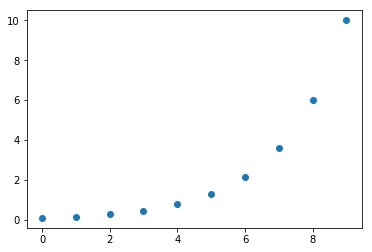

In [431]:
f_list = np.logspace(-1, 1, 10)
for f in f_list:
    print "{:f}".format(f)
plt.plot(f_list, 'o')

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


#### Debug algorithm with learning curve

In [ ]:
# TODO

#### Final evaluation on the test set

In [ ]:
classifier.score(X_test, y_test)

In [97]:
from statsmodels.tsa.seasonal import seasonal_decompose

'''
w = 3
s = 10
print zip( range(0, s-w), range(w, s) )
for start, end in zip(range(0, s-w),range(w, s)):
    print request_cnt_dat[start: end]
'''

i = 0
ws = 6 * 10 * 24 * 4 + 2
ts = len(request_cnt_dat)
for start, end in zip(range(0, ts-ws),range(ws, ts))[11000:]:
    if i % 10 == 0: print i
    i += 1
    if i == 60*3: break
    window = request_cnt_dat[start: end]['count']
    #print d
    result = seasonal_decompose(window, model='additive', freq=24*6*10, two_sided=False)
    idx = window.index[-1]
    
    mean = result.resid.mean()
    std = result.resid.std()
    resid = result.resid[-1]
    request_cnt_dat.loc[idx, 'resid_mean'] = mean
    request_cnt_dat.loc[idx, 'resid_std'] = std
    request_cnt_dat.loc[idx, 'resid'] = resid
    request_cnt_dat.loc[idx, 'sigma'] = (resid - mean) / std
    
    #result.plot()
    #figure = result.plot()
    #figure.set_size_inches((20,10))
    #break

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170


In [96]:
(10880)+(60*2)

11000

In [ ]:
pd.set_option('display.width', 150)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

#request_cnt_dat[request_cnt_dat['resid'].notnull()].loc['2015-12-11 00:00:00':'2015-12-12 00:00:00'].sort_values(['sigma'], ascending=[False])[:100]
#request_cnt_dat[request_cnt_dat['resid'].notnull()].loc['2015-12-18 16:00:00':'2015-12-18 19:00:00'].sort_values(['sigma'], ascending=[False])[:100]
request_cnt_dat[request_cnt_dat['resid'].notnull()].loc['2015-12-18 15:00:00':'2015-12-18 19:00:00']


#### Decomposition

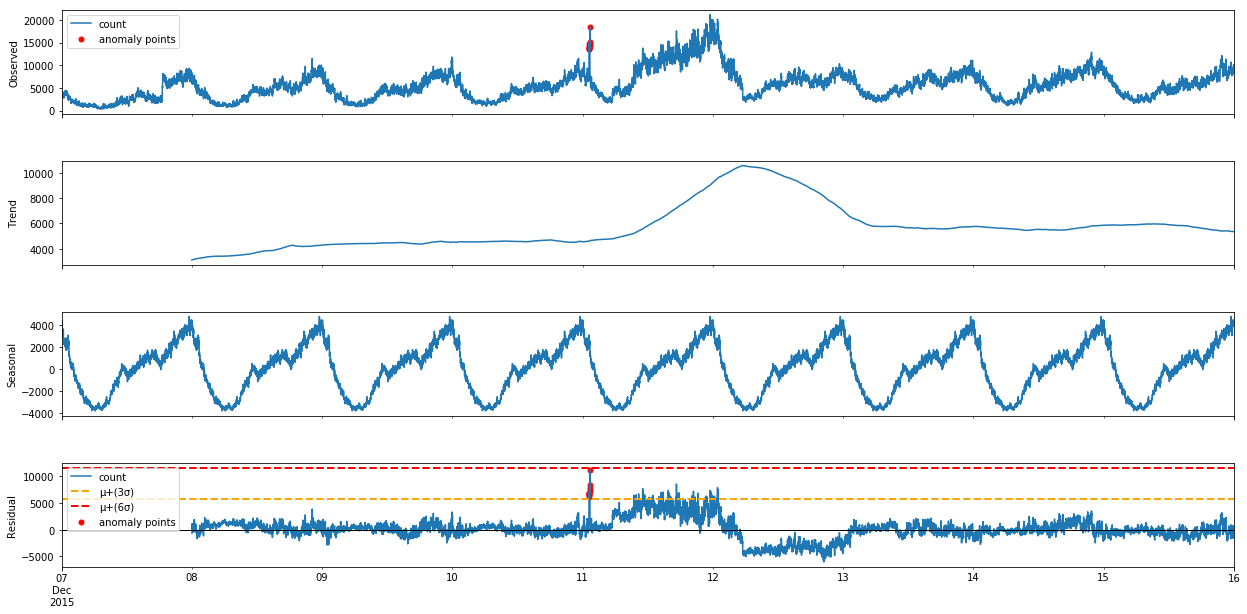

In [28]:
# MEMO : decompose 과정에서 missing value 처리 불가. 이상 데이터 제외시키지는 못함. 수작업으로 처리한다면, 앞/뒤 평균으로 덮어씌워 처리 가능할 듯.. 
# TODO : seasonal_decompose 함수에서 기본적으로 사용하는 이동평균 기간은???

from statsmodels.tsa.seasonal import seasonal_decompose
# model : additive / multiplicative
result = seasonal_decompose(X_train['count'], model='additive', freq=24*6*10, two_sided=False)
#result = seasonal_decompose(X_train['count'], model='additive', freq=24*6, two_sided=False)
#result = seasonal_decompose(X_train['count'], model='additive', two_sided=False)

figure = result.plot()
figure.set_size_inches((20,10))

ax = figure.axes[0]
ax.scatter(result.observed.index, X_train['anomaly'], color='red', marker='o', s=5**2, label='anomaly points')
ax.legend(loc="upper left")

ax = figure.axes[3]
X_train.loc[y_train['y']==0, 'anomaly_resid'] = np.nan
X_train['anomaly_resid'].update(result.resid[y_train['y']==1])
ax.scatter(X_train.index, X_train['anomaly_resid'], color='red', marker='o', s=5**2, label='anomaly points')
ax.axhline(y=0, linewidth=1, linestyle='-', color='black')
ax.axhline(y=result.resid.mean()+(3.0*result.resid.std()), linewidth=2, linestyle='dashed', color='orange', label=u'μ+(3σ)')
ax.axhline(y=result.resid.mean()+(6.0*result.resid.std()), linewidth=2, linestyle='dashed', color='red', label=u'μ+(6σ)')

ax.legend(loc="upper left")

plt.show()

#### Probability Distribution of the Residual

In [ ]:
mean = result.resid.mean()
std = result.resid.std()
ax = result.resid.hist(bins=20)
#threshold = mean + (3.2*std)
#threshold = mean+(5.0*std)
ax.axvline(x=mean+(2.0*std), linewidth=2, linestyle='dashed', color='orange')
ax.axvline(x=mean+(5.0*std), linewidth=2, linestyle='dashed', color='red')
#ax.axvline(x=result.resid['2015-12-18 17:00:00'], linewidth=2, linestyle='dashed', color='red')
#ax.axvline(x=result.resid['2015-12-18 17:10:00'], linewidth=2, linestyle='dashed', color='red')
#ax.axvline(x=result.resid['2015-12-18 17:20:00'], linewidth=2, linestyle='dashed', color='red')
#ax.axvline(x=result.resid['2015-12-18 17:30:00'], linewidth=2, linestyle='dashed', color='red')
figure = ax.get_figure()
figure.set_size_inches((7,10))
plt.show()

#### 판단 기준
 - 값 : 값을 그대로 이용할 경우 학습 시킬 때 글로벌 최적화에 불리하다. (불가능하지는 않지만 학습 시킬 때 효율화 시키기 어려움.)
 - 확률 : 소수의 량은 무조건 positive 로 판단하여, 이상점이 없어도 False Positive 가 매번 발생할 것.
 - 시그마 수준 : 변동성이 클 경우 취약할 수 도 있을것 같긴 하지만(추후 생각해 보기), 이 방법이 제일 괜찮아 보임.

#### 학습 데이터의 양과 질
- 필요한 데이터가 제대로 들어 있나? (=양과 질이 적당한가?)
 - 이상 탐지에 있어서는 _이상 패턴이 모두 포함되어 있어야_ 적당하다고 볼 수 있을 것.
 - 일부 동일 패턴만 많으면 소용 없음.

#### 데이터 전처리
- 학습/교차검증/테스트 데이터 세트로 나누기.
- 학습 데이터에서 이상 패턴 출현 구간들만 샘플링.
 - Negative 데이터는 제외하고 Positive 데이터만 취하는 이유는 학습의 효율화를 위함.
 - 구간을 추출하는 이유는 슬라이딩 윈도우 방식을 이용하여 학습할 것이기에.

#### 학습과 예측
- 지도학습(Supervised Learning) 방식.
- 슬라이딩 윈도우 방식으로 학습하고 그 다음 데이터를 예측.
- 윈도우 크기와 시그마 수준을 머신러닝으로 최적화.
 - 윈도우 크기 : 작으면 효율적&불안정, 크면 비효율적&안정.
 - 시그마 수준 : 낮으면 , 높으면 .
 - 시그마 수준 최적화 시, 윈도우 사이즈를 늘려 평균과 표준편차를 안정화 시킨다. --> 평균과 표준편차가 안정화된다면, 자엽스럽게 시그마 수준도 안정될 것.

#### 평가
- 러닝커브

#### 다양한 해상도에 대해 어떤 연산을 적용해야 할까? or / and 응응에 따라 다를까?

#### 어떻게 이상하냐?
 - 정도의 차이 : 단지 사용량이 는것.
 - 모양의 차이 : 정말 이상한 것.


#### 가설함수

In [ ]:
# 얼마 동안의 데이터에 대한 평균과 표준편차를 기준으로 해야 할까? 주어진(윈도우 사이즈로) 데이터 기준?

def hypothesis(X, theta):
    if x > mean + ( c * std ):
        pred = True
    else:
        pred = False
    return pred

    

    formula(theta, x)
    return 

def H(X, mean, std, theta):
    if x > mean + ( c * std ):
        pred = True
    else:
        pred = False
    return pred

mean = 
std = 
c = 
y = H(x, mean, std, c)
print y

#### 비용함수

In [ ]:
def J(x, epsilon):
    
    return 

y = f(x)
print y

#### 최적화

In [ ]:
epsilon = 0.0001



#### 

#### 

#### 가설함수 & 비용함수

#### Optimization

In [ ]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

from sklearn import metrics
print metrics.classification_report(y_test, y_pred)

#### Evaluation

In [ ]:
'''
from sklearn import metrics
metrics.classification_report(y_true, y_pred)
metrics.confusion_matrix(y_true, y_pred[, …])
roc auc
'''

#### 데이터 시각화

In [ ]:
def plot(df):
    plt.figure(figsize=(20,6))
    
    plt.plot(df.index, df['count'], linestyle='solid', marker='o')
    plt.plot(df.index, df['MA20'], linestyle='solid')
    #plt.plot(df.index, df['EWMA20'], linestyle='solid')

    #threshold = df['MA20'] + ( 3.35 * df['MS60'] )
    #threshold_label = 'anomaly boundary\nMA20 + ( 3.35 * MS20 )'
    #plt.plot(df.index, threshold, linestyle='dashed', label=threshold_label)
    
    #threshold_EW = df['EWMA5'] + ( 0.85 * df['EWMS5'] )
    #threshold_label_EW = 'anomaly boundary\nEWMA5 + ( 0.85 * EWMS5 )'
    #plt.plot(df.index, threshold_EW, linestyle='dashed', label=threshold_label_EW)
    
    #anomaly = df[df['count'] > threshold]
    #if not anomaly.empty: print "[anomaly points]\n", anomaly
    #plt.plot(anomaly.index, anomaly['count'], 's',label='anomaly points', color='purple', linewidth=8, 
    #         marker='x', markeredgecolor='purple', markeredgewidth=5, markersize=10, alpha=0.5)
    
    if 'predict' in df.columns:
        plt.plot(df.index, df['predict'], 's',label='predict', color='purple', linewidth=8, 
                 marker='x', markeredgecolor='purple', markeredgewidth=5, markersize=10, alpha=0.5)
    if 'y' in df.columns:
        plt.plot(df.index, df['y'], 's',label='y', color='red', linewidth=8, 
                 marker='x', markeredgecolor='purple', markeredgewidth=5, markersize=10, alpha=0.5)
    
    #ax = plt.gca()
    #ax2 = ax.twinx()
    #ax2.plot(df['pct_change'], color='red')

    #ax = plt.gca()
    #ax2 = ax.twinx()
    #ax2.plot(df['detrend'], color='red', linewidth=3)

    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

'''
plot(request_cnt['2015-12-01':'2015-12-31'])
plot(request_cnt_t['2015-12-01':'2015-12-31'])
plot(request_cnt_10t['2015-12-01':'2015-12-31'])
plot(request_cnt_60t['2015-12-01':'2015-12-31'])
'''

#plot(request_cnt_t['2015-12-07':'2015-12-31'])


plot(request_cnt_10t['2015-12-07':'2015-12-31'])
plot(request_cnt_10t['2015-12-18 00:00:00':'2015-12-19 09:00:00'])
plot(request_cnt_10t['2015-12-18 16:00:00':'2015-12-19 02:00:00'])
#request_cnt_t['2015-12-18 16:00:00':'2015-12-18 18:00:00']


#plot(request_cnt_60t['2015-12-07':'2015-12-31'])
#plot(request_cnt_10t['2015-12-23':'2015-12-26'])
#plot(request_cnt_10t['2015-12-17':'2015-12-20'])
#plot(request_cnt['2015-12-18 21:47:25':'2015-12-18 21:47:25'])
#plot(request_cnt['2015-12-25':'2015-12-26'])

#plot(request_cnt['2015-12-25 22:24:16':'2015-12-25 23:24:16'])
#plot(request_cnt['2015-12-24 09:00':'2015-12-24 09:01'])
#plot(request_cnt['2015-12-18 21:47:00':'2015-12-18 21:48:00'])
#plot(request_cnt['2015-12-24 09:00':'2015-12-24 09:30'])
#plot(request_cnt['2015-12-24 12:00':'2015-12-24 12:30'])
#plot(request_cnt['2015-12-24 18:00':'2015-12-24 18:30'])
#plot(request_cnt['2015-12-24 23:00':'2015-12-24 23:30'])


#### 가상 시나리오 적용
 1. 서비스 거부 공격 : 요청 건수가 급격하게 늘어나는 상황.
 2. ~~시스템 장애 : 요청 건수가 급격하게 줄어드는 상황. (TODO)~~

In [ ]:
# TODO

# 1. 서비스 거부 공격
#np.random.random_sample()
#np.linspace(0, 2*np.pi, 10)
#cnt = request_cnt['2015-12-18 21:46:00':'2015-12-18 21:49:00'].count()
#request_cnt['2015-12-18 21:47:00':'2015-12-18 21:48:00']['count'] = request_cnt['2015-12-18 21:47:00':'2015-12-18 21:48:00']['count'] * 5
request_cnt.loc['2015-12-18 21:47:20':'2015-12-18 21:47:40', 'count'] = request_cnt.loc['2015-12-18 21:47:20':'2015-12-18 21:47:40', 'count'] + 1000
request_cnt['MA20'] = request_cnt['count'].rolling(20).mean()
request_cnt['MS20'] = request_cnt['count'].rolling(20).std()
request_cnt['EWMA20'] = request_cnt['count'].ewm(com=1, min_periods=20).mean()
request_cnt['EWMS20'] = request_cnt['count'].ewm(span=20, min_periods=20).std()
#halflife span com

#for i in range(cnt):
#    r = np.random.random_sample()
#    request_cnt['count']['2015-12-18 21:46:00'] = 3000 * r
    
# 2. 시스템 장애


In [ ]:
#request_cnt.sort_values(['count'], ascending=[False])[:10]
#plot(request_cnt[970:1100])
plot(request_cnt['2015-12-18 21:47:00':'2015-12-18 21:48:00'])

####  이상 탐지

In [ ]:
# 정렬
#anomaly = request_cnt[request_cnt['count'] > request_cnt['MA20']+(4*request_cnt['MS20'])]
anomaly = request_cnt[request_cnt['count'] > request_cnt['MA20']+(4*request_cnt['MS20'])]
anomaly.sort_values(['count'], ascending=[True])#[:10]
# 4.24852925

# 첫번째 이상 데이터 시각화
#plot(request_cnt['2015-10-24 07:17:30':'2015-10-24 07:20:00'])
#plot(request_cnt['2015-10-24 22:40:10':'2015-10-24 22:40:40'])
#plot(request_cnt['2015-11-04 13:51:00':'2015-11-04 13:51:20'])
#plot(request_cnt['2015-10-24 10:45:20':'2015-10-24 10:47:30'])
#request_cnt['2015-10-24 07:17:30':'2015-10-24 07:20:00']

#plot(request_cnt['2015-10-24 05:31:10':'2015-10-24 05:31:30'])
#request_cnt['2015-10-24 05:31:10':'2015-10-24 05:31:30']

#plot(request_cnt['2015-11-17 17:56:20':'2015-11-17 17:56:50'])
#plot(request_cnt['2015-11-17 17:56:45':'2015-11-17 17:56:50'])

#plot(request_cnt['2015-11-06 11:19:00':'2015-11-06 11:20:00'])

#### 평가

In [ ]:
# TODO
'''
from sklearn import metrics
metrics.classification_report(y_true, y_pred)
metrics.confusion_matrix(y_true, y_pred[, …])
roc auc
'''

#### 최적화
 1. anomaly boundary : 
 2. 이동 평균 윈도우 크기 : 중심. 짧으면 false negative(미탐), 길면 false positive(오탐).
 3. 이동 표준편차 윈도우 크기 : 변동. 
 4. 시간축 해상도 : 

#### 개선 필요
 - 값이 0에서 놀다가 갑자기 증가하는 경우 개선 필요.
 - 이상 시작점 뿐만 아니라 진행중인 구간에서도 탐지할 수 있도록.

#### 메모
 - 응용에 따라 식과 파라미터 최적화가 필요함.
 - 응용에 따라 수치가 0에서 10으로 높아지는 경우 이상하다고 판단할 수 도 없을 수도 있다.
 - 바로 이전과 비교? 전체를 기준으로 비교?
 

### 2. 클라이언트 수 이상 탐지

In [ ]:
# TODO

### 3. 응답 크기 이상 탐지

In [ ]:
# TODO

In [ ]:
#request_cnt.sort_values(['count'], ascending=[False])#[:10]
#print request_cnt.count()
request_cnt['EWMA20'] = request_cnt['count'].ewm(com=0.5, min_periods=20).mean()
request_cnt['EWMS20'] = request_cnt['count'].ewm(com=0.5, min_periods=20).std()
#halflife span
#plot(request_cnt['2015-10-24 05:31:10':'2015-10-24 05:31:30'])

In [ ]:


#request_cnt_10t['EWMA5'] = request_cnt_10t['count'].ewm(com=1, min_periods=5).mean()
#request_cnt_10t['EWMS5'] = request_cnt_10t['count'].ewm(span=5, min_periods=5).std()

In [ ]:
ax = result.resid.plot()
f = ax.get_figure()
f.set_size_inches((10.7,1.5))

pdf = request_cnt_10t['2015-12-07':'2015-12-31']
pdf['predict'] = result.resid[result.resid > threshold]

if not pdf['predict'].empty: print "[anomaly points]\n", pdf['predict'][pdf['predict'] > threshold]
ax.scatter(pdf.index, pdf['predict'], color='red', marker='o', s=10**2)
plt.show()

request_cnt_10t['predict'] = np.nan
request_cnt_10t['predict'].update(request_cnt_10t.loc[pdf[pdf['anomaly'].notnull()].index, 'count'])


#### 가설함수 & 비용함수

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', penalty='l2', warm_start=True)
clf.fit(X_train, y_train)
print 'coef : ', clf.coef_
print 'intercept : ', clf.intercept_
print 'n_iter : ', clf.n_iter_

y_pred = clf.predict(X_test)

from sklearn import metrics
print metrics.classification_report(y_test, y_pred, target_names=['nomal', ''])
#metrics.confusion_matrix(y_true, y_pred[, …])
#roc auc


In [ ]:
from sklearn.svm import SVC
estimator = SVC(kernel='linear')

from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=2, test_size=0.2, random_state=0)

from sklearn.grid_search import GridSearchCV
gammas = np.logspace(-6, -1, 2)
classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=dict(gamma=gammas))
classifier.fit(X_train, y_train)

from sklearn.learning_curve import learning_curve
title = 'Learning Curves (SVM, linear kernel, $\gamma=%.6f$)' % classifier.best_estimator_.gamma
estimator = SVC(kernel='linear', gamma=classifier.best_estimator_.gamma)
#plot_learning_curve(estimator, title, X_train, y_train, cv=cv)
#plt.show()


#### SciPy 연습

In [ ]:
import scipy as sp

#plt.figure(figsize=(10, 5))

# x 축 데이터 생성
x = np.linspace(-5, 5, 100)
mean = x.mean()
std = x.std()

rv = sp.stats.norm(loc=0, scale=1) # 정규 분포 랜덤변수 객체 생성 (평균:0, 표준편차:1)
plt.plot(rv.rvs(size=100))
plt.grid(True)
plt.title('Random Value')
plt.show()

plt.plot(x, rv.pdf(x), label='PDF') # 확률 밀도 함수 (Probability Density Function)
plt.plot(x, rv.cdf(x), label='CDF') # 누적 밀도 함수 (Cumulative Density Function)

# 
#z = np.insert(np.diff(y), 0, None)
#w = ( 10 - (-10) ) / 100.0
#plt.bar(x-w, z/w, width=w, alpha=0.3, label='bar')

plt.legend(loc="best")
plt.grid(True)
plt.title('pdf/cdf')
plt.show()


In [ ]:
rv = sp.stats.norm(loc=0, scale=10)
#help(rv.rvs)
v = rv.rvs(size=100)
#print v
plt.plot(v)


ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)

In [ ]:
#print sp.stats.describe(x)

#mu, sigma = 0, 1
#print np.random.normal(mu, sigma, 10)

In [ ]:
# MEMO : decompose 과정에서 missing value 처리 불가. 이상 데이터 제외시키지는 못함. 수작업으로 처리한다면, 앞/뒤 평균으로 덮어씌워 처리 가능할 듯.. 
# TODO : seasonal_decompose 함수에서 기본적으로 사용하는 이동평균 기간은???

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(request_cnt_dat.loc['2015-12-07':'2015-12-31', 'count'], model='additive', freq=24*6*10, two_sided=False)
#result = seasonal_decompose(request_cnt_dat.loc['2015-12-07':'2015-12-31', 'count'], model='additive', freq=24*6, two_sided=False)
#result = seasonal_decompose(request_cnt_dat.loc['2015-12-07':'2015-12-31', 'count'], model='additive', two_sided=False)

pdf = request_cnt_dat.loc['2015-12-07':'2015-12-31', ['y']]
pdf.insert(0, 'X', result.resid)
pdf.loc[pdf['y']==0, 'anomaly'] = np.nan
pdf['anomaly'].update(result.resid[pdf['y']==1])

figure = result.plot()
figure.set_size_inches((20,10))

ax = figure.axes[0]
ax.scatter(result.observed.index, request_cnt_dat.loc['2015-12-07':'2015-12-31', 'anomaly'], color='red', marker='o', s=5**2, label='anomaly points')
ax.legend(loc="best")

ax = figure.axes[3]
ax.scatter(pdf.index, pdf['anomaly'], color='red', marker='o', s=5**2, label='anomaly points')
ax.axhline(y=0, linewidth=1, linestyle='-', color='black')
ax.axhline(y=result.resid.mean()+(6*result.resid.std()), linewidth=1, linestyle='dashed', color='red', label='mu+(6*sigma)')

ax.legend(loc="best")

plt.show()

In [ ]:

class TSML(object):
    '''
        Time Series Machine Learning
    '''
    def __init__(self, window_size=30, sigma=5):
        self.window_size = window_size
        self.sigma = sigma
        
    def split(self, df, test_size=0.2): # Helper Method
        train_size = 1.0 - test_size
        idx = int( len(df) * train_size )
        train, test = df[:idx], df[idx-self.window_size:]
        return train, test
    
    def fit(self, X, y incr=True):
        # 
        return 
        
    def predict(self, X, y):
        # 
        return 
        
    def learning_curve(self, t, X, y): # Helper Method
        # 
        return 
        
    def validation_curve(self, t, X, y): # Helper Method
        # 
        return 

    def GridSearch(self, t, X, y): # Helper Method
        # 
        return 

# grace_period=10, train_sizes=[], test_size=1, level=10

# TODO : 적당한 데이터 예제로 바꾸기 (sklearn 에 이미 들어 있는?)
# http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

#data_path = 'Bike-Sharing-Dataset/hour.csv'
#rides = pd.read_csv(data_path)
'''
df = pd.DataFrame(index=X_train.index)
df['X_count'] = X_train[['count']]
df['y'] = y_train['y']
df
'''
tsml = TSML()
print tsml.split(df, test_size=0.2)


In [ ]:

#########################################################################
'''
X_train, X_test, y_train, y_test = \
request_cnt_dat.loc[:'2015-12-16 00:00:00', ['count', 'anomaly']], \
request_cnt_dat.loc['2015-12-16 00:00:00':, ['count', 'anomaly']], \
request_cnt_dat.loc[:'2015-12-16 00:00:00', ['y']], \
request_cnt_dat.loc['2015-12-16 00:00:00':, ['y']]
'''
#SIZE = 10
#request_cnt_dat.loc['2015-12-11 01:10:00':'2015-12-11 01:19:00', 'y'] = 1

'''
##########
# 러닝커브(X, y, 윈도우 크기 목록)
# 
# for 윈도우 크기 in 윈도우 크기 목록:
#     이상점 목록 구하기.
#     for 이상점 in 이상점 목록:
#         시작점 = 이상점 - 윈도우 크기
#         끝점 = 이상점
#             데이터[시작점:끝점]의 평균과 표준편차.
#         시그마 수준 = 
시그마 수준과 ... 사이의 관계

시계열에 적합한 tratified split : 클래스 종이 최대한 양쪽에 균긍하게 들어가도록 하는 시점을 찾아 나누기.

데이터 양이 달라지면(learning_curve) 파라미터도 그에 맞게 최적화 시켜야(validation_curve) 하는거 아닌가?
 => 보통 예에서 파라미터 최적화 시킨 후, 데이터양을 최적화 시키는데, 이 둘을 개별적이 아닌 동시에 최적화 시켜야 하지 않나!
'''

In [ ]:
# 클린징 (null 제거)
#ml_data = pdf[pdf['X'].notnull()][['X', 'y']]

# 스케일링
# TODO : 해야 하나? 그럼 어떤 방식으로?
'''
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
'''


# 정리

- 시계열 데이터 이상 탐지를 위한 모델 학습과 예측 순서 (지도 학습 기반)
- 전처리와 학습을 배치로 한 번 실행하고, 그 이후 부터는 전처리와 예측을 실시간으로. 그리고 관리적인 부분도 함께 진행.

### 전처리
01. (전처리) 빅데이터 요약 : 로그 데이터 집계
02. (전처리) 시계열 변환 : 기준 단위로 샘플링 (샘플링 단위 : 용도에 맞는 단위 선택해야. 신속함/정확성의 정도.)
03. (전처리) y 생성 : 데이터를 시각화하고 이상점을 찾아 수동으로 마킹. (실시간 처리 시에는 모델 예측 결과 저장)
04. (전처리) X 생성 : 매 시점 슬라이딩 윈도우 구간에 대해 decomposition 하고 해당 시점 잔차의 시그마 수준을 구함. (윈도우 사이즈 달리하여 여러 특성 시도)
05. (전처리) Normalization (TODO)

### 학습
06. (전처리) Train/Test 데이터셋 나누기. (StratifiedShuffleSplit)
07. (모델 생성) 선형 분류 모델 생성.
08. (검증 곡선) Validation Curve : 하이퍼파라미터 최적화를 위한 개별 하이퍼파라미터 탐색 범위를 정하기 위한 단계. (scoring=recall)
09. (하이퍼파라미터 최적화) Tune Hyperparameters : 최적의 하이퍼파라미터 찾기. (scoring=recall)
10. (학습 곡선) Learning Curve : train 데이터셋 양이 더 많을 경우 도움이 될지 판단. (scoring=recall)
11. (학습 및 평가) 모델에 train 데이터 학습시키고, 다양한 메트릭을 이용하여 평가.
12. (예측 및 평가) 학습된 모델을 이용하여 test 데이터에 대해 예측하고, 다양한 메트릭을 이용하여 평가.
13. (최종 모델 학습) 전체 데이터 학습.

### 예측
14. (예측) 새로운 입력 X 에 대한 예측 결과를 y에 저장.

### 관리
15. False Positive & False Negative 등에 대해 y 값을 수동으로 수정.
16. 모델 학습을 재진행. (더 고민이 필요한 부분)
